In [1]:
# Problem Set #7
# Dennis Cruz dec2174
# Collaborators: Edward Sanchez, es2903

# ! python -m pip install lightkurve --upgrade #Already installed

# Problem 1

In [2]:
import lightkurve as lk
import numpy as np
import math as m
import scipy.integrate as integrate

import matplotlib.pyplot as plot
%matplotlib inline                  

# Make displayed plots larger
plot.rcParams['figure.figsize'] = [18, 11]

In [3]:
def get_lightcurve(name):
    lcs      = lk.search_lightcurve(name, mission="Kepler", cadence="short").download_all()
    time     = np.array(lcs[0].time.value)          # get the time of each observation
    flux     = np.array(lcs[0].flux.value.data)     # get the flux
    flux_err = np.array(lcs[0].flux_err.value.data) # get the error in the flux
    return (time, flux, flux_err)

In [4]:
(time, flux, flux_err) = get_lightcurve("Kepler-7b")

In [5]:
# Testing data is imported correctly:
print(time)

[260.21486737 260.21554845 260.21622962 ... 290.55545371 290.55613488
 290.55681595]


In [6]:
# Obtaining time, flux and flux error for a certain time:

def masking (ti, tf):
    mask = np.logical_and(time>ti, time<tf) # np.logical_and allows you to have 2 conditions on the mask
    time_range  = time[mask]                 # ti, obtains the values of time between 261 and 262
    flux_range  = flux[mask]                 # Fi, flux range
    f_err_range = flux_err[mask]             # uncertainty in the flux
    return (time_range, flux_range, f_err_range)

In [31]:
# Testing:
time_range, flux_range, f_err_range = masking(261,262)
print(len(time_range), len(flux_range), len(f_err_range))
print (time_range)

1456 1456 1456
[261.00017066 261.00085173 261.00153281 ... 261.99797534 261.99865651
 261.99933759]


In [8]:
# Obtaining Average and Standard Deviation from extracted flux values:

def mean(flx):
    mean_flx = np.mean(flx)    # F bar prime, mean of the extracted flux values
    return mean_flx

def standard_d(flx):    
    st_dev_flx = np.std(flx)  # sigma prime, standard deviation of the extracted flux values
    return st_dev_flx


In [9]:
#Testing:
print (standard_d(flux_range), mean(flux_range))

287.75525 106457.66


In [10]:
# Excluding transit from flux data:


def two_sigma(flx):
    actual_flux = []                                  # array of fluxes excluding the transit    

    # Removing points:
    for i in range(len(flx)):
        excluded_points = m.fabs(flx[i] - mean(flx))/standard_d(flx) # removing points
        if excluded_points < 2:
            actual_flux.append(flx[i])
    accurate_flux = actual_flux
    return accurate_flux

In [11]:
# Testing:

print (len(two_sigma(flux_range)), len(flux_range)) # Actual flux has less elements than flux_range


1297 1456


In [12]:
# Iterating to obtain a good estimate of the resulting values:

def iterations(flx, k):
    
    for j in range (k):
    
        accurate_flux = two_sigma(flx)   # Starts excluding data and retrieves a new flux
        flx = accurate_flux              # So the next iteration will be with the new values
        
    return accurate_flux

In [13]:
# Testing:

print (len(iterations(flux_range, 5))) # lenght of values is less than previos fluxes 
final_flux = iterations(flux_range, 5)

1060


In [14]:
# Obtaining last mean and standard deviation:

std_d_prime = standard_d(final_flux)  # Std deviation double prime i.e. "final"
F_bar       = mean(final_flux)        # Mean double prime i.e. "final"

print(std_d_prime, F_bar)             # lower standard deviation than og flux range

41.842335 106595.22


In [137]:
# Normalizing:

norm_flux     = flux_range/F_bar           # Normalized Flux (Fi)
norm_flux_err = f_err_range/std_d_prime    # Normalized Uncertainty in the flux (sigmaF,i)

print(norm_flux, norm_flux_err)

[0.9996699 1.0003825 1.0001546 ... 1.001422  0.9993011 0.9994306] [1.2414656 1.2421666 1.243359  ... 1.2466111 1.2436031 1.2437819]


In [16]:
# Model Fitting:

# Limb-darkening relation:
def I(r):
    u = (1-r**2)**1/2
    return u**1/2

# Test:
I(3)

-2.0

In [17]:
# Defining Ratio of Obscured to unobscured
def delta (p, r, z): #function for different conditions of delta
    
    if r >= (z + p) or r <= (z - p):
        result = 0.0
        return result
        
    elif (r + z) <= p:
        result = 1
        return result
        
    else:
        k_value = (z**2 - p**2 + r**2) / (2.0*z*r) # Value to evaluate acos
        if -1 <= k_value <= 1:                     # Boundaries of acos to avoid math error
            k = m.acos (k_value)                   # "k" variable substitutes the equation
            result = (1/m.pi) * k
        return result
# Testing delta function for different "r":
#for r in np.arange (0, 1.5, 0.5):
#    print (r, delta(0.2, r, 0.9))

In [18]:
# Defining integrals:

def function_numer (r):                          # numerator function inside the integral
    return (I(r) * (1 - delta(p, r, z) * 2 * r)) # ratio of two integrals with no limb darkening, i.e. I(r) = 1

def function_denom (r):                          # denominator function inside the integral
    return (I(r) * 2.0 * r) 


In [66]:
# Solving integrals:

p = 0.0775  # ratio of the planet radius to the stellar radius
tau = 0.1   # duration of eclipse
t0 = 261.3  # time of maximal eclipse

F_transit = []  # List to keep track of all the values of the ratio at different times
I_denom, err = integrate.quad(function_denom, 0, 1) # Denominator integral

def z_t (t_i, t0, tau):                                 # Function z(t)
    return ((t_i - t0) / float(tau))

# Calculating for different time ranges
for t_i in time_range:
    z = z_t(t_i, t0, tau)                               # Calculates  at different times
    I_numer, err = integrate.quad(function_numer, 0, 1) # Numerator integral
    ratio = I_numer / float(I_denom)
    F_transit.append(ratio)
    #print (I_numer, err)

# Test
print (len(F_transit)) # same lenght as values of Fi and time

1456


In [164]:
# Computing X square:

chi_list = []
chi_square = 0

for N in range(len(time_range)):            # N = points in the light curve
    fraction = ((norm_flux[N] - F_transit[N])/norm_flux_err[N])**2  
    chi_square += fraction                  # Sums it all together
    chi_list.append(fraction)

print(chi_square)

104.43993813236585


# Problem 2:

In [181]:
# Plotting data and the predicted transit curve on top of each other:

def graph(x_axis, y_axis, name, c, tlt ):
    plt.title(tlt)
    plt.plot(x_axis, y_axis, label = name, color = c)
    plt.xlabel('Time')
    plt.ylabel('Flux')
    plt.legend(loc="best")
    plt.show()
    return

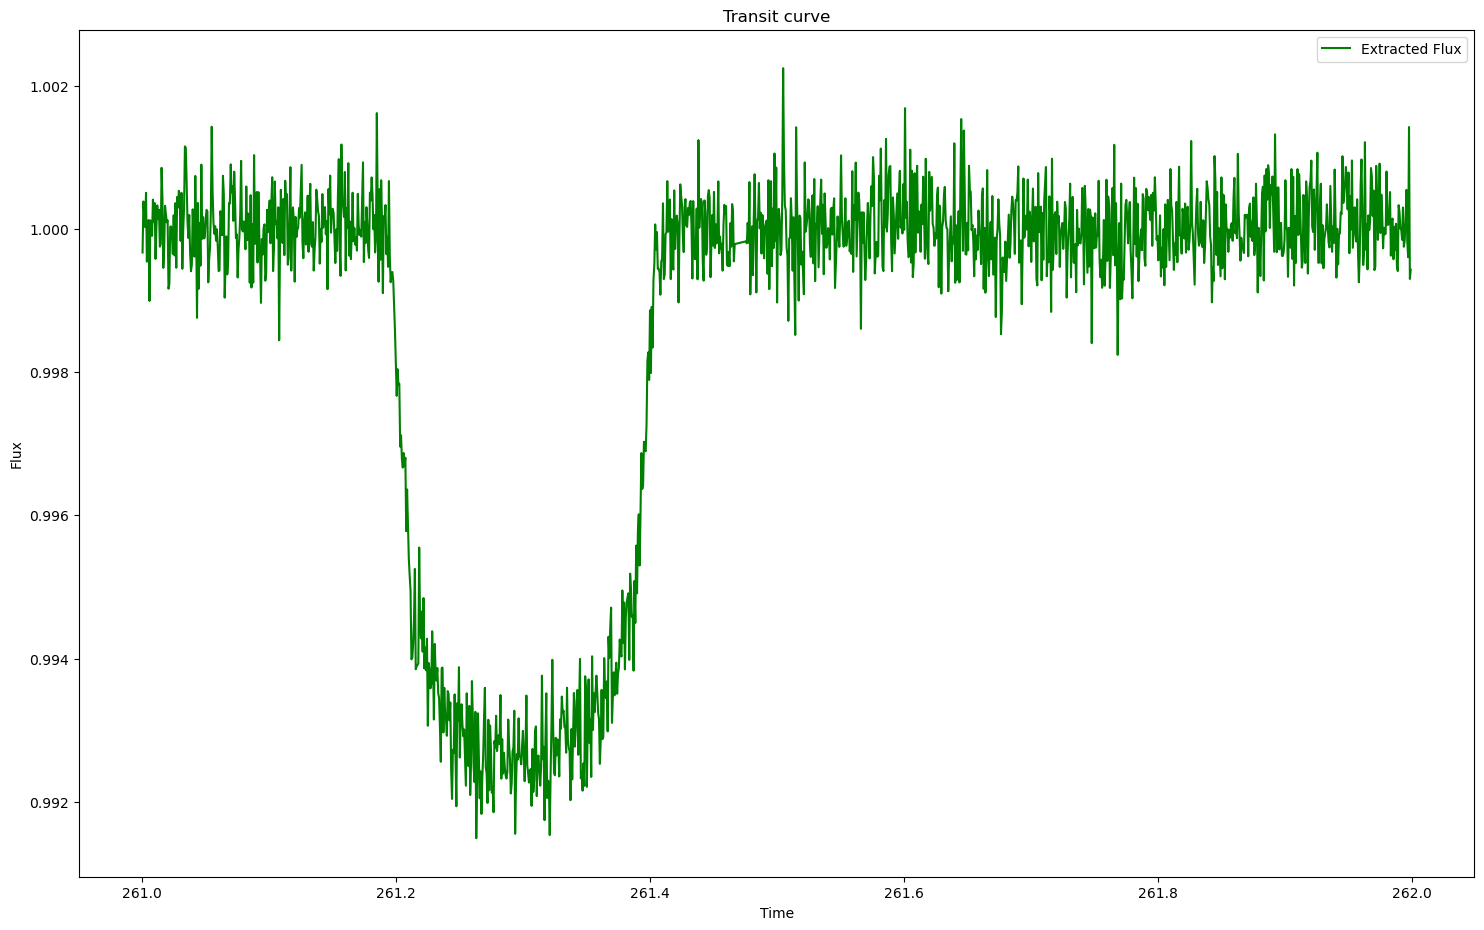

In [93]:
graph(time_range, norm_flux, "Extracted Flux", "Green", "Transit curve")

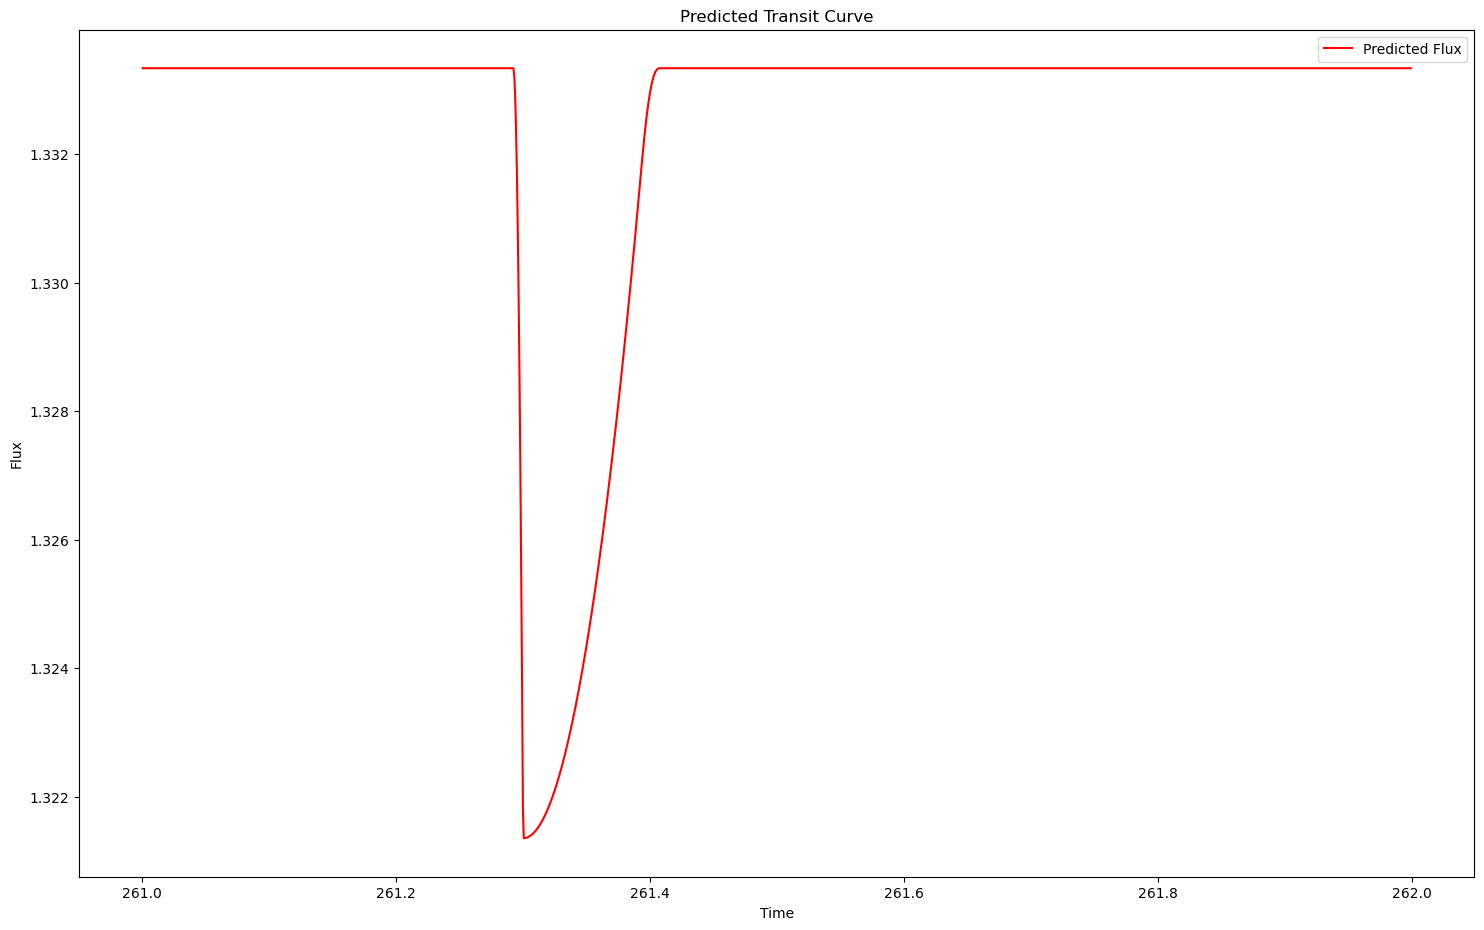

In [98]:
graph(time_range, F_transit, "Predicted Flux", "red", "Predicted Transit Curve")

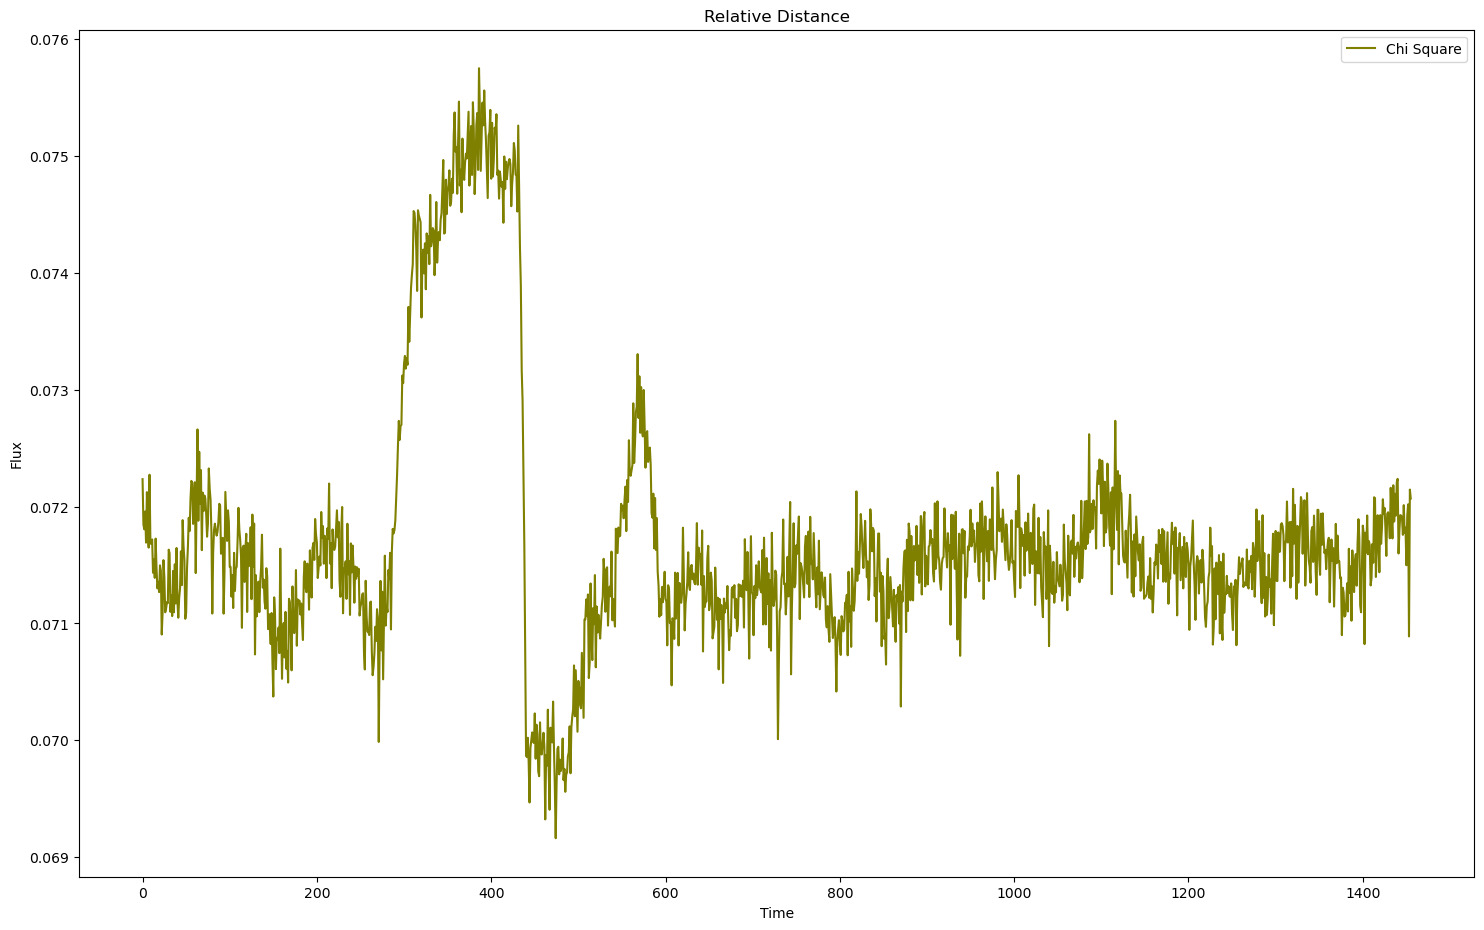

In [165]:
graph(range(len(time_range)), chi_list, "Chi Square", "olive", "Relative Distance")

When trying to fit both models on top of each other there is a difference of 0.3 seconds so they are ploted separately. In the case of the transit, both predicted and extracted values seem to have the lowest flux at the same time, this means the predicted flux is somewhat accurate except for the fact that the transit lasts longer on the retrieved data.

In [143]:
# Computing how likely the value of Chi square is:

#Incomplete Gamma Function:

def mu (points, M):
    N = points      # Number of data points
    v = N - M       # M = number of fitted parameters
    return v

def integrand (t, a):
    return np.exp(-t) * t**(a - 1)
    
def gamma_f (a, x):
    top = integrate.quad(integrand, x, np.inf, args = (a))[0]
    bottom = integrate.quad(integrand, 0, np.inf, args = (a))[0]
    result = top / bottom
    return result

In [149]:
v = mu(len(time_range), 3)
vec_expint = np.vectorize(gamma_f)

gamma = gamma_f (v/2, chi_square/2)


OverflowError: (34, 'Result too large')

Im not sure how to solve this error for the integral. I am guessing it is because the boundaries of integration is infinity? 

# Problem 3:

In [182]:
# Varying tau parameter between 0.08 and 0.13

# Creates new variables for all
F_transit_2  = []
chi_list_2   = []
chi_sq_sum   = []
chi_square_2 = 0

# Calculating for different time ranges
for tau in np.arange(0.08, 0.14, 0.01):
    
    for t_i in time_range:
        z = z_t(t_i, t0, tau)                                 # Calculates  at different times
        I_numer_2, err = integrate.quad(function_numer, 0, 1) # Numerator integral
        ratio_2 = I_numer_2 / float(I_denom)
        F_transit_2.append(ratio_2)
    
    # Integrates chi loop to obtain every chi value at different taus
    for N in range(len(time_range)):            # N = points in the light curve
        fraction_2 = ((norm_flux[N] - F_transit_2[N])/norm_flux_err[N])**2  
        chi_square_2 += fraction_2                  # Sums it all together
        chi_list_2.append(fraction_2)
        
    chi_sq_sum.append(chi_square_2)
    
    # Emptying lists and value to evaluate at next chi
    F_transit_2   = []
    chi_square_2 = 0

In [183]:
# Obtaining minimum chi value

print(len(chi_sq_sum))
print(len(np.arange(0.08, 0.14, 0.01)))

# Correct, there should be 7 chi square values for every tau

print (chi_sq_sum)
print (np.arange(0.08, 0.14, 0.01))

chi_min = min(chi_sq_sum)
print (chi_min)


7
7
[104.54511805850534, 104.49250012574679, 104.43993813236585, 104.38760698224691, 104.33549255903968, 104.2835519513114, 104.23169480176354]
[0.08 0.09 0.1  0.11 0.12 0.13 0.14]
104.23169480176354


Minimum Chi square is 104.23169 at tau = 0.14. For some reason when I create the range from 0.08 to 0.14 the result includes 0.14, so I used this value as the minimum

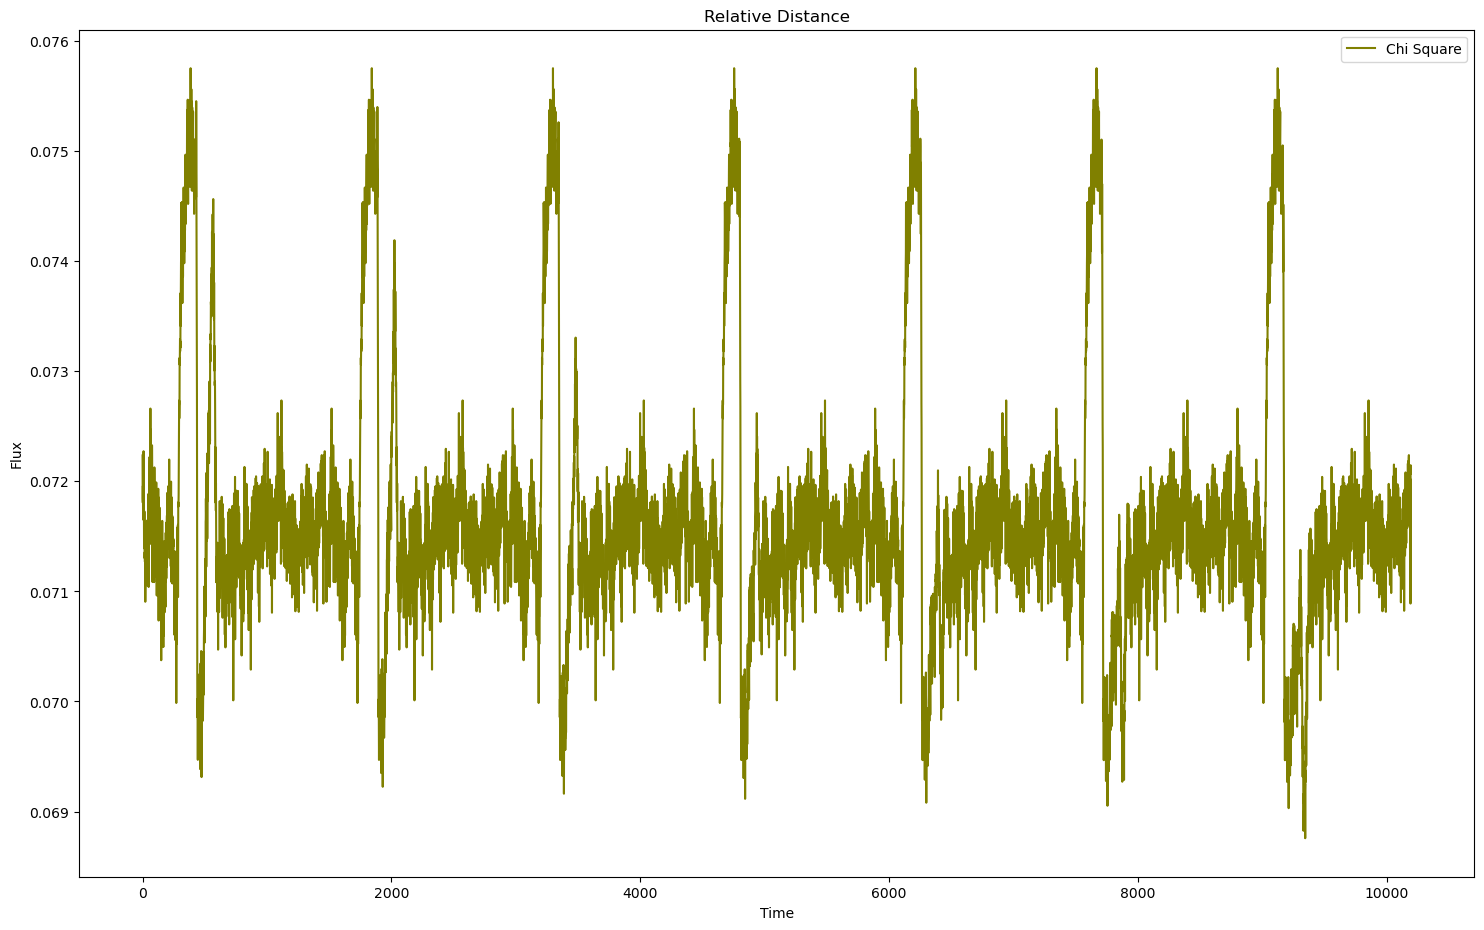

In [188]:
graph(range(len(chi_list_2)), chi_list_2, "Chi Square", "olive", "Relative Distance")

Based on the Chi-squared plot, the uncertainty lies on the last tau based on the lowest value. There is a lower dip in the last interval so uncertainty lies more or less at point 9700.